IMPORTS,LIBRARIES,& INSTALLATIONS

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import skimage.feature as skf


Collection & Preprocessing phase

Before the images are inspected, I want to view the categorization of them across the training,testing, and validation sets.

In [3]:
# Define dataset paths
dataset_path = r"C:\Users\ME\OneDrive\Documents\400 level\winter-spring semester\Machine Learning\chest_xray" # Change this to your actual dataset path
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")
test_path = os.path.join(dataset_path, "test")

# Function to count images in each category
def count_images(folder_path):
    normal_count = len(os.listdir(os.path.join(folder_path, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(folder_path, "PNEUMONIA")))
    return normal_count, pneumonia_count

# Count images in train, val, and test sets
train_normal, train_pneumonia = count_images(train_path)
val_normal, val_pneumonia = count_images(val_path)
test_normal, test_pneumonia = count_images(test_path)

# Print summary
print(f"Train Set: {train_normal} Normal, {train_pneumonia} Pneumonia")
print(f"Validation Set: {val_normal} Normal, {val_pneumonia} Pneumonia")
print(f"Test Set: {test_normal} Normal, {test_pneumonia} Pneumonia")


Train Set: 1341 Normal, 3875 Pneumonia
Validation Set: 8 Normal, 8 Pneumonia
Test Set: 234 Normal, 390 Pneumonia


Cool,nice to see the breakdown. Its interesting the size the validation set. Now i wanna see the images themselves

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Clean ImageDataGenerator (No Augmentation)
train_datagen = ImageDataGenerator(rescale=1./255)  #  Only normalize images
val_datagen = ImageDataGenerator(rescale=1./255)    #  No augmentation in validation
test_datagen = ImageDataGenerator(rescale=1./255)   #  No augmentation in test

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  
    color_mode="grayscale",  
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


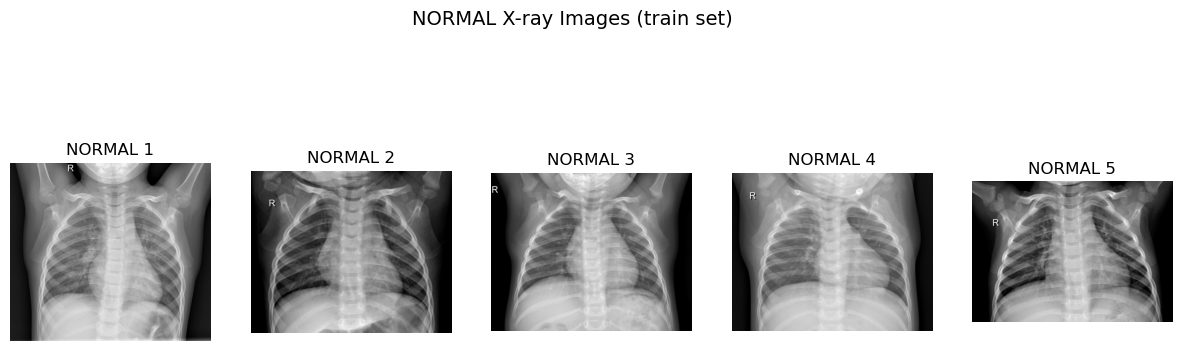

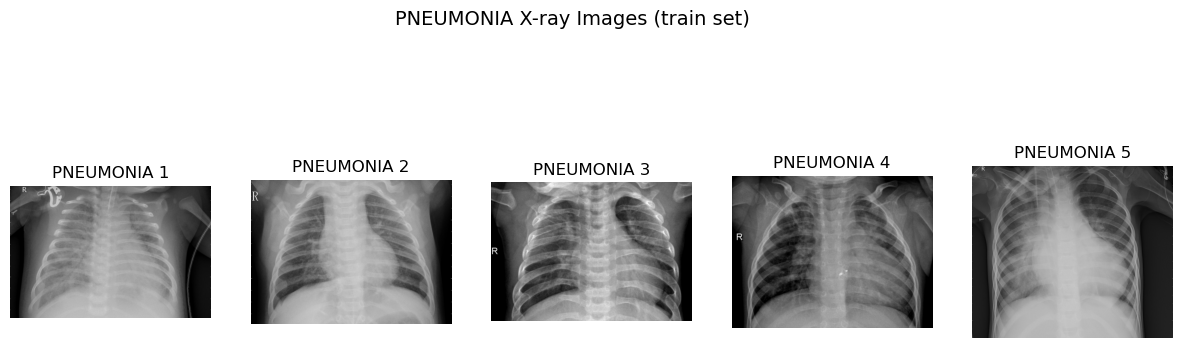

In [5]:
# Function to load and display multiple images
def show_multiple_images(category, dataset="train", n=5):
    folder = os.path.join(dataset_path, dataset, category)
    image_names = os.listdir(folder)[:n]  # Pick first 'n' images
    
    fig, axes = plt.subplots(1, n, figsize=(15, 5))  # Create a row of 'n' plots
    for i, image_name in enumerate(image_names):
        img_path = os.path.join(folder, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{category} {i+1}")
        axes[i].axis("off")
    
    plt.suptitle(f"{category} X-ray Images ({dataset} set)", fontsize=14)
    plt.show()

# Show 5 images from each category
show_multiple_images("NORMAL", "train", n=5)
show_multiple_images("PNEUMONIA", "train", n=5)


Since deep learning models require structured input, we need to load all images into NumPy arrays for training.

In [6]:
IMG_SIZE = (224, 224)  # Resize images for consistency

# Function to load images into NumPy arrays
def load_images_from_folder(folder):
    images = []
    labels = []
    
    for category in ["NORMAL", "PNEUMONIA"]:
        category_path = os.path.join(folder, category)
        label = 0 if category == "NORMAL" else 1  # Assign 0 to Normal, 1 to Pneumonia

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            
            # Load and preprocess
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)  # Resize
            img = img / 255.0  # Normalize
            
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training, validation, and test sets
X_train, y_train = load_images_from_folder(train_path)
X_val, y_val = load_images_from_folder(val_path)
X_test, y_test = load_images_from_folder(test_path)

# Print dataset shapes
print(f"Train Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Data: {X_test.shape}, Labels: {y_test.shape}")


Train Data: (5216, 224, 224), Labels: (5216,)
Validation Data: (16, 224, 224), Labels: (16,)
Test Data: (624, 224, 224), Labels: (624,)


Exploratory Data Analysis Phase

Since X-ray images are grayscale, let’s visualize pixel intensity distribution. This tells us if images are too dark/bright

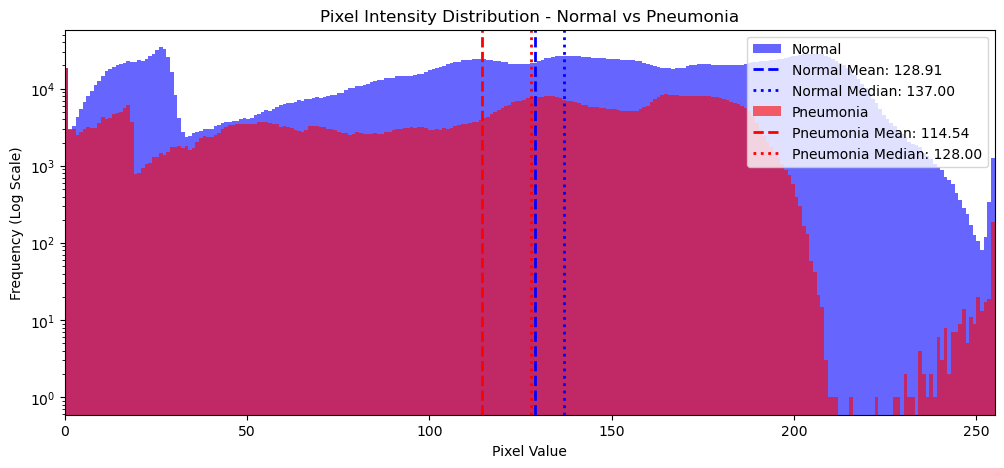

In [7]:
# Function to plot pixel intensity distribution for NORMAL vs PNEUMONIA
def plot_pixel_intensity_comparison(normal_path, pneumonia_path):
    normal_img = cv2.imread(normal_path, cv2.IMREAD_GRAYSCALE)
    pneumonia_img = cv2.imread(pneumonia_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 5))

    # Histogram for NORMAL
    plt.hist(normal_img.ravel(), bins=256, color='blue', alpha=0.6, label="Normal")
    plt.axvline(normal_img.mean(), color='blue', linestyle='dashed', linewidth=2, label=f'Normal Mean: {normal_img.mean():.2f}')
    plt.axvline(np.median(normal_img), color='blue', linestyle='dotted', linewidth=2, label=f'Normal Median: {np.median(normal_img):.2f}')

    # Histogram for PNEUMONIA
    plt.hist(pneumonia_img.ravel(), bins=256, color='red', alpha=0.6, label="Pneumonia")
    plt.axvline(pneumonia_img.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Pneumonia Mean: {pneumonia_img.mean():.2f}')
    plt.axvline(np.median(pneumonia_img), color='red', linestyle='dotted', linewidth=2, label=f'Pneumonia Median: {np.median(pneumonia_img):.2f}')

    plt.title("Pixel Intensity Distribution - Normal vs Pneumonia")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency (Log Scale)")
    plt.xlim(0, 255)
    plt.yscale("log")  # Log scale for better visibility
    plt.legend()
    plt.show()

# Define paths to sample images
normal_sample = os.path.join(train_path, "NORMAL", os.listdir(os.path.join(train_path, "NORMAL"))[0])
pneumonia_sample = os.path.join(train_path, "PNEUMONIA", os.listdir(os.path.join(train_path, "PNEUMONIA"))[0])

# Run the improved function
plot_pixel_intensity_comparison(normal_sample, pneumonia_sample)


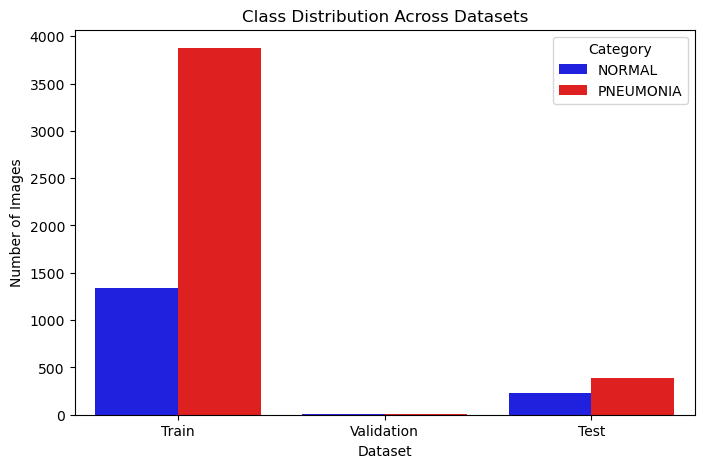

In [8]:
# Class distribution dictionary
data_counts = {
    "Train": [train_normal, train_pneumonia],
    "Validation": [val_normal, val_pneumonia],
    "Test": [test_normal, test_pneumonia]
}

# Convert to DataFrame
categories = ["NORMAL", "PNEUMONIA"]
df_counts = []
for dataset, counts in data_counts.items():
    for category, count in zip(categories, counts):
        df_counts.append({"Dataset": dataset, "Category": category, "Count": count})

df_counts = pd.DataFrame(df_counts)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="Dataset", y="Count", hue="Category", data=df_counts, palette=["blue", "red"])
plt.title("Class Distribution Across Datasets")
plt.ylabel("Number of Images")
plt.show()


Feature Engineering Section

To highlight lung structures, we can apply edge detection using Canny filtering

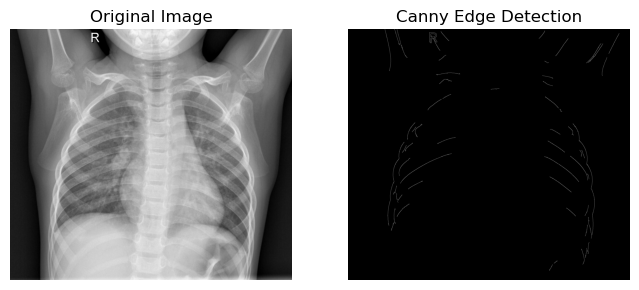

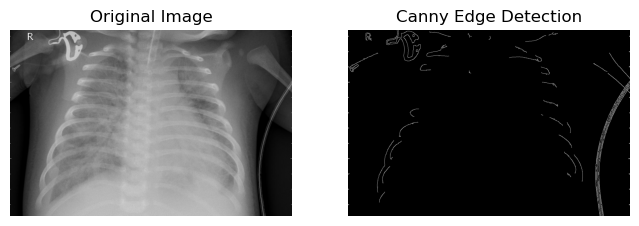

In [9]:
# Function to apply edge detection
def apply_canny_edge(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 50, 150)  # Adjust thresholds if needed

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis("off")

    plt.show()

# Run on one image
apply_canny_edge(normal_sample)
apply_canny_edge(pneumonia_sample)


Shape-Based Features (Lung Region Analysis) -  Lung abnormalities due to pneumonia may change lung shape, area, and perimeterd due to fluid buildup

In [10]:
def extract_contour_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))
    
    # Apply thresholding to detect lung region
    _, thresh = cv2.threshold(img_resized, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)  # Get largest contour
        area = cv2.contourArea(largest_contour)  # Compute area
        perimeter = cv2.arcLength(largest_contour, True)  # Compute perimeter
    else:
        area, perimeter = 0, 0  # If no contour is found, assign zero

    return area, perimeter

# Example usage
shape_features = extract_contour_features(normal_sample)
print("Shape Features (Area, Perimeter):", shape_features)


Shape Features (Area, Perimeter): (32675.0, 1203.518893957138)


Pneumonia cases often have different frequency patterns in images. Fourier Transform helps extract frequency components for classification.

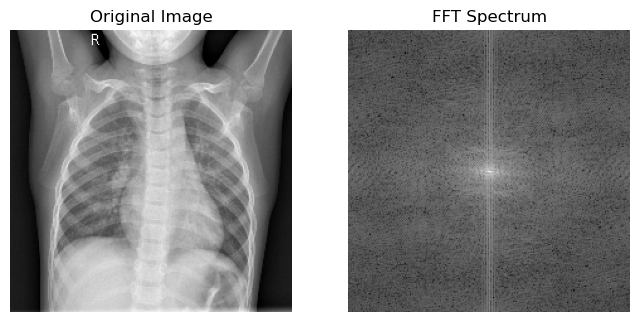

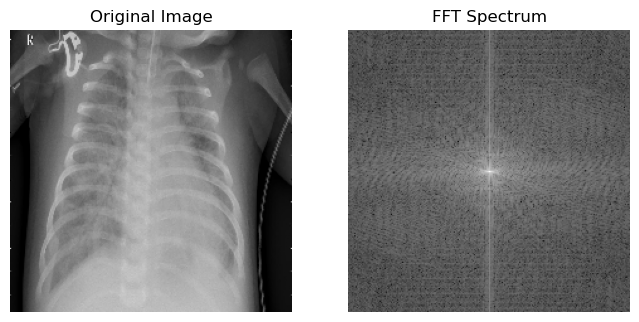

In [11]:
def compute_fft(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))

    f_transform = np.fft.fft2(img_resized)  # Compute 2D Fourier Transform
    f_shift = np.fft.fftshift(f_transform)  # Shift low frequencies to center
    magnitude_spectrum = 20 * np.log(np.abs(f_shift))  # Convert to log scale

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title("FFT Spectrum")
    plt.axis("off")

    plt.show()

# Apply FFT
compute_fft(normal_sample)
compute_fft(pneumonia_sample)


Texture Features (GLCM - Gray Level Co-occurrence Matrix). X-ray images have different texture patterns between normal and pneumonia cases. GLCM captures texture differences between healthy and pneumonia-infected lungs.

In [12]:
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM texture features
def extract_glcm_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
    img_resized = cv2.resize(img, (224, 224))  # Resize for consistency

    # Compute GLCM and extract texture features
    glcm = graycomatrix(img_resized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, homogeneity, energy, correlation

# Example usage
glcm_features = extract_glcm_features(normal_sample)
print("GLCM Features:", glcm_features)


GLCM Features: (143.26755685458042, 0.19097287795800275, 0.017031461133857895, 0.9813838938796839)


Next I extract all texture features, for each image in the train, validation, and test sets and store them in a DataFrame.

In [13]:
import pandas as pd
import os

# Function to extract contour shape features
def extract_contour_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))

    _, thresh = cv2.threshold(img_resized, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
    else:
        area, perimeter = 0, 0

    return area, perimeter

# Function to extract Fourier Transform features
def extract_fft_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))

    f_transform = np.fft.fft2(img_resized)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(1 + np.abs(f_shift))  # Log scaling for better visualization

    mean_freq = np.mean(magnitude_spectrum)
    std_freq = np.std(magnitude_spectrum)

    return mean_freq, std_freq

# Function to extract edge detection features
def extract_edge_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))

    edges = cv2.Canny(img_resized, 50, 150)  # Canny edge detection
    edge_density = np.sum(edges) / (224 * 224)  # Ratio of edge pixels to total pixels

    return edge_density

# Function to extract all features and merge them
def extract_all_features(img_path):
    contrast, homogeneity, energy, correlation = extract_glcm_features(img_path)
    area, perimeter = extract_contour_features(img_path)
    mean_freq, std_freq = extract_fft_features(img_path)
    edge_density = extract_edge_features(img_path)

    return [contrast, homogeneity, energy, correlation, area, perimeter, mean_freq, std_freq, edge_density]

# Process dataset and merge features
def process_dataset(folder_path):
    data = []
    
    for category in ["NORMAL", "PNEUMONIA"]:
        category_path = os.path.join(folder_path, category)
        label = 0 if category == "NORMAL" else 1  # Assign labels

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                features = extract_all_features(img_path)
                data.append([img_name, label] + features)
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    return data

# Define column names
columns = [
    "Image_Name", "Label",
    "Contrast", "Homogeneity", "Energy", "Correlation",  # GLCM Features
    "Area", "Perimeter",  # Contour Features
    "Mean_Freq", "Std_Freq",  # FFT Features
    "Edge_Density"  # Edge Detection Features
]

# Extract and save merged features
train_data = process_dataset(train_path)
val_data = process_dataset(val_path)
test_data = process_dataset(test_path)

df_train = pd.DataFrame(train_data, columns=columns)
df_val = pd.DataFrame(val_data, columns=columns)
df_test = pd.DataFrame(test_data, columns=columns)

df_train.to_csv("train_combined_features.csv", index=False)
df_val.to_csv("val_combined_features.csv", index=False)
df_test.to_csv("test_combined_features.csv", index=False)

print("Feature extraction and merging complete! CSV files saved.")


Feature extraction and merging complete! CSV files saved.


Model Training Phase 

Before building the CNN Model, it is best to load images for CNN, load extracted features, merge both as a single dataset

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import cv2

# Load extracted features
train_features = pd.read_csv("train_combined_features.csv")
val_features = pd.read_csv("val_combined_features.csv")
test_features = pd.read_csv("test_combined_features.csv")

# Function to load image and preprocess for CNN
def load_images_from_folder(folder_path):
    images = []
    labels = []

    for category in ["NORMAL", "PNEUMONIA"]:
        category_path = os.path.join(folder_path, category)
        label = 0 if category == "NORMAL" else 1  # Assign labels
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))  # Resize
            img = img / 255.0  # Normalize
            
            images.append(img)
            labels.append(label)

    return np.array(images).reshape(-1, 224, 224, 1), np.array(labels)

# Load image data
X_train_img, y_train = load_images_from_folder(train_path)
X_val_img, y_val = load_images_from_folder(val_path)
X_test_img, y_test = load_images_from_folder(test_path)

# Load feature data (drop Image_Name column)
X_train_features = train_features.drop(columns=["Image_Name", "Label"]).values
X_val_features = val_features.drop(columns=["Image_Name", "Label"]).values
X_test_features = test_features.drop(columns=["Image_Name", "Label"]).values

# Verify shapes
print(f"Train Image Data Shape: {X_train_img.shape}, Feature Shape: {X_train_features.shape}")
print(f"Validation Image Data Shape: {X_val_img.shape}, Feature Shape: {X_val_features.shape}")
print(f"Test Image Data Shape: {X_test_img.shape}, Feature Shape: {X_test_features.shape}")


Train Image Data Shape: (5216, 224, 224, 1), Feature Shape: (5216, 9)
Validation Image Data Shape: (16, 224, 224, 1), Feature Shape: (16, 9)
Test Image Data Shape: (624, 224, 224, 1), Feature Shape: (624, 9)


Then the CNN model is built with feature integration, this will be a dual-input model where one input takes images through a CNN while the other input input takes hand-crafted features through a Dense layer. The outputs from both are concatenated before classification.


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate

# CNN Branch (for Images)
cnn_input = Input(shape=(224, 224, 1))
x = Conv2D(32, (3,3), activation='relu', padding='same')(cnn_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Feature Branch (for Extracted Features)
feat_input = Input(shape=(X_train_features.shape[1],))
y = Dense(64, activation='relu')(feat_input)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)

# Merge CNN and Feature Branch
merged = Concatenate()([x, y])
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(64, activation='relu')(merged)

#  Corrected Output Definition
output = Dense(1, activation='sigmoid')(merged)  # Properly define output tensor

# Define Model
model = Model(inputs=[cnn_input, feat_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             640 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 28, 28, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 100352)            │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 100416)            │               0 │ flatten[0][0],             │
│                               │                           │                 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │      12,853,376 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 12,955,265 (49.42 MB)

 Trainable params: 12,955,137 (49.42 MB)

 Non-trainable params: 128 (512.00 B)

In [16]:
# Convert feature arrays **before** passing to the generator
X_train_features = np.asarray(X_train_features, dtype=np.float32)
X_val_features = np.asarray(X_val_features, dtype=np.float32)
X_test_features = np.asarray(X_test_features, dtype=np.float32)

# Check data type before using in generators
print("Final Feature Data Type Before Generator:", X_train_features.dtype)


Final Feature Data Type Before Generator: float32


Created a custom generator that loads both image and feature inputs together for training.

In [17]:
import tensorflow.keras.utils as keras_utils
import numpy as np
import tensorflow as tf

class HybridDataGenerator(keras_utils.Sequence):
    def __init__(self, image_generator, feature_data, batch_size):
        self.image_generator = image_generator
        self.feature_data = np.array(feature_data, dtype=np.float32)  #  Ensure `float32`
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        # Get batch of images and labels from ImageDataGenerator
        image_batch, labels = self.image_generator[index]

        # Get corresponding feature batch
        start = index * self.batch_size
        end = start + self.batch_size
        feature_batch = self.feature_data[start:end]

        #  Explicitly convert everything to `tf.float32` tensors
        image_batch = tf.convert_to_tensor(image_batch, dtype=tf.float32)
        feature_batch = tf.convert_to_tensor(feature_batch, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)  #  Ensure labels are tensors

        return (image_batch, feature_batch), labels


Reinitialize the Hybrid Generator

In [18]:
batch_size = 32  # Or whatever batch size you prefer
train_hybrid_generator = HybridDataGenerator(train_generator, X_train_features, batch_size)
val_hybrid_generator = HybridDataGenerator(val_generator, X_val_features, batch_size)


Double Check what is being generated

In [19]:
# Get a sample batch (Images, Features, Labels)
(sample_images, sample_features), sample_labels = train_hybrid_generator[0]

print("Image Batch Shape:", sample_images.shape)
print("Feature Batch Shape:", sample_features.shape)
print("Labels Shape:", sample_labels.shape)
print("Image Data Type:", sample_images.dtype)
print("Feature Data Type:", sample_features.dtype)
print("Labels Data Type:", sample_labels.dtype)


Image Batch Shape: (32, 224, 224, 1)
Feature Batch Shape: (32, 9)
Labels Shape: (32,)
Image Data Type: <dtype: 'float32'>
Feature Data Type: <dtype: 'float32'>
Labels Data Type: <dtype: 'float32'>


Model Training

In [20]:
history = model.fit(
    train_hybrid_generator,
    validation_data=val_hybrid_generator,
    epochs=20,
    steps_per_epoch=len(train_hybrid_generator),
    validation_steps=len(val_hybrid_generator)
)


C:\Users\ME\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.8228 - loss: 0.3653 - val_accuracy: 0.7500 - val_loss: 0.4204
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9599 - loss: 0.1095 - val_accuracy: 0.6875 - val_loss: 0.5439
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9690 - loss: 0.0845 - val_accuracy: 0.8750 - val_loss: 0.1881
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9746 - loss: 0.0623 - val_accuracy: 0.6875 - val_loss: 0.6243
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9807 - loss: 0.0548 - val_accuracy: 0.7500 - val_loss: 0.6127
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9884 - loss: 0.0366 - val_accuracy: 0.9375 - val_loss: 0.2431
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9908 - loss: 0.0236 - val_accuracy: 0.7500 - val_loss: 0.5207
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9939 - loss: 0.0160 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8750 - loss: 0.5814
Validation Loss: 0.5814, Validation Accuracy: 0.8750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.75      0.86         8
   Pneumonia       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



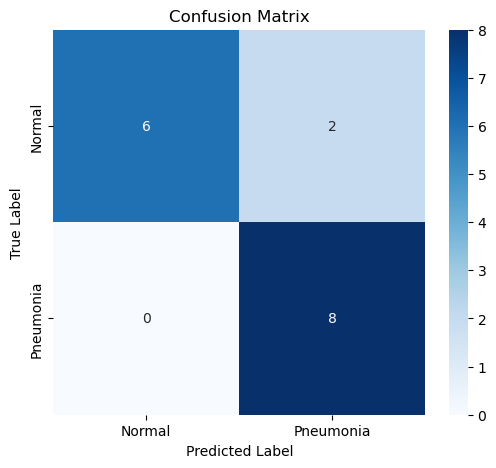

ROC-AUC Score: 1.0000


In [21]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on validation set
eval_results = model.evaluate(val_hybrid_generator)
print(f"Validation Loss: {eval_results[0]:.4f}, Validation Accuracy: {eval_results[1]:.4f}")

# Get predictions (probabilities)
y_pred_probs = model.predict(val_hybrid_generator)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Get true labels from the generator
y_true = np.concatenate([val_hybrid_generator[i][1] for i in range(len(val_hybrid_generator))])

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Key Takeaways from the Classification Report
Precision & Recall:

Normal Class: Precision is 1.00, meaning when the model predicts Normal, it's always correct. However, recall is 0.75, meaning it missed some actual Normal cases.

Pneumonia Class: Recall is 1.00, meaning it found all Pneumonia cases, but precision is 0.80, so some false positives exist.
F1-Score:

Both classes have high F1-scores (~0.86-0.89), indicating solid performance.

Accuracy (88%) is great for medical classification, but with only 16 test samples, it’s too small to generalize.